# Polars Tutorial Part 4

https://www.youtube.com/watch?v=w26V2p9fC5A&list=PLo9Vi5B84_dfAuwJqNYG4XhZMrGTF3sBx&index=6

### Group-by & RFM analysis
- Recency: did they make a purchase recently?
- Frequency: How often do they make a purchase?
- Monetary: How much do they spend?

In [32]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyarrow
import seaborn as sns

In [12]:
data_file = "/Users/alex/.cache/kagglehub/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/versions/8/2019-Nov.csv"
df = pl.read_csv(
    data_file,
)

In [13]:
df.shape

(67501979, 9)

In [14]:
df.head()

event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
str,str,i64,i64,str,str,f64,i64,str
"""2019-11-01 00:00:00 UTC""","""view""",1003461,2053013555631882655,"""electronics.smartphone""","""xiaomi""",489.07,520088904,"""4d3b30da-a5e4-49df-b1a8-ba5943…"
"""2019-11-01 00:00:00 UTC""","""view""",5000088,2053013566100866035,"""appliances.sewing_machine""","""janome""",293.65,530496790,"""8e5f4f83-366c-4f70-860e-ca7417…"
"""2019-11-01 00:00:01 UTC""","""view""",17302664,2053013553853497655,null,"""creed""",28.31,561587266,"""755422e7-9040-477b-9bd2-6a6e8f…"
"""2019-11-01 00:00:01 UTC""","""view""",3601530,2053013563810775923,"""appliances.kitchen.washer""","""lg""",712.87,518085591,"""3bfb58cd-7892-48cc-8020-2f17e6…"
"""2019-11-01 00:00:01 UTC""","""view""",1004775,2053013555631882655,"""electronics.smartphone""","""xiaomi""",183.27,558856683,"""313628f1-68b8-460d-84f6-cec7a8…"


In [23]:
# date conversion in polars
df = df.with_columns(
    pl.col("event_time").str.to_date(
        format="%Y-%m-%d %H:%M:%S %Z"
    )
)

In [29]:
df.filter(pl.col("user_id") == 520088904).sample(5)

event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
date,str,i64,i64,str,str,f64,i64,str
2019-11-19,"""view""",9101665,2053013552888807671,"""computers.peripherals.mouse""","""defender""",10.79,520088904,"""f443e47a-f346-47b5-82fb-6a2c40…"
2019-11-15,"""view""",4802960,2053013554658804075,"""electronics.audio.headphone""","""harper""",20.28,520088904,"""bb7e87b8-0aa6-48b1-97a6-3178a2…"
2019-11-13,"""view""",4800675,2053013554658804075,"""electronics.audio.headphone""","""sony""",14.93,520088904,"""e9882787-2f34-4cbd-80b0-70a8d0…"
2019-11-01,"""view""",1003898,2053013555631882655,"""electronics.smartphone""","""oneplus""",540.3,520088904,"""4d3b30da-a5e4-49df-b1a8-ba5943…"
2019-11-08,"""view""",4800970,2053013554658804075,"""electronics.audio.headphone""","""sony""",13.02,520088904,"""277ff36f-3e74-44b4-b573-03cf7c…"


### 1. keep rows with purchases only

In [30]:
df_purchases = df.filter(
    pl.col("event_type") == "purchase"
)

In [31]:
df_purchases.shape

(916939, 9)

### 2. Let's compute RFM

In [35]:
# select unique purchases

df_purchases = df_purchases.select([
    "event_time", "user_id", "price"
]).unique()

In [40]:
# i'm dropping more data than he did. why? 
# something to do with differences in date parsing?
# or a change in polars since 0.20?

df_purchases.shape

(808798, 3)

In [37]:
df_purchases.head()

event_time,user_id,price
date,i64,f64
2019-11-17,555142820,204.36
2019-11-25,547615663,416.97
2019-11-24,532599375,19.82
2019-11-20,565672551,465.39
2019-11-03,566994804,141.55


#### compute time difference

In [41]:
# last date of the dataset
# so we can compute time difference from then

anchor_date = datetime(2019, 11, 30)

In [45]:
df_purchases = df_purchases.with_columns(
    (anchor_date - pl.col("event_time")).alias("date_diff")
)

In [46]:
df_purchases.head()

event_time,user_id,price,date_diff
date,i64,f64,duration[μs]
2019-11-17,555142820,204.36,13d
2019-11-25,547615663,416.97,5d
2019-11-24,532599375,19.82,6d
2019-11-20,565672551,465.39,10d
2019-11-03,566994804,141.55,27d


In [51]:
df_agg = (df_purchases
    .group_by("user_id")
    .agg([
        pl.col("date_diff").min().alias("recency"),
        pl.len().alias("frequency"),
        pl.col("price").sum().alias("monetary"),
    ])
)

In [52]:
df_agg.shape

(441638, 4)

In [53]:
df_agg.head()

user_id,recency,frequency,monetary
i64,duration[μs],u32,f64
525473843,14d,2,802.85
529679960,18d,1,123.17
566730599,27d,2,47.34
515580353,8d,1,102.94
574416613,9d,1,125.1


### 3. convert to pandas for analysis and plotting

In [54]:
df_agg = df_agg.to_pandas()

In [56]:
breaks = np.arange(0., 1.1, 0.1)
num_vars = ["recency", "frequency", "monetary"]
df_agg[num_vars].quantile(breaks)

,recency,frequency,monetary
0.0,0 days,1.0,0.770
0.1,2 days,1.0,42.470
0.2,5 days,1.0,80.830
0.3,9 days,1.0,127.350
0.4,13 days,1.0,169.370
0.5,13 days,1.0,237.030
0.6,13 days,1.0,311.564
0.7,16 days,2.0,463.070
0.8,20 days,2.0,737.960
0.9,25 days,3.0,1255.596


<Axes: >

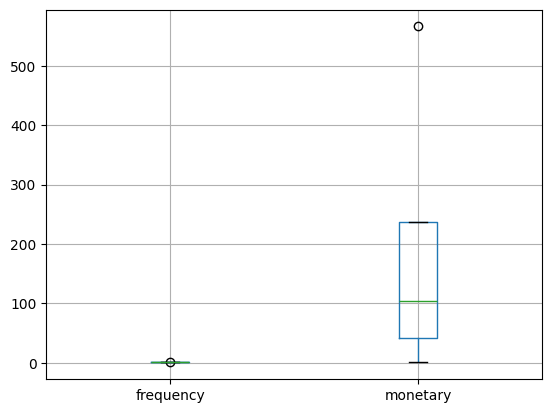

In [59]:
df_agg[num_vars].quantile([0., 0.25, 0.5, 0.75, 0.1]).boxplot()